In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
from google.colab import drive
from PIL import Image
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from tensorflow.keras import optimizers
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import io
import pandas as pd


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dataset

local_download_path = os.path.expanduser('/content/drive/My Drive/Images')
img = []
for filename in os.listdir(local_download_path): 
  for images in os.listdir(os.path.join(local_download_path,filename)):
    temp = Image.open(os.path.join(os.path.join(local_download_path,filename),images))
    temp = temp.convert('L')
    img.append([images,temp.resize((800,800))])

img.sort() 

In [0]:
input_x = 128
input_y = 128
output_x = 512
output_y = 512

# input image dimensions
img_rows, img_cols, img_channels = 128, 128, 1
input_shape = (img_rows, img_cols, img_channels)


In [0]:
def map_data(dataset,start_index, end_index, input_x, input_y, output_x, output_y):
  
  data = []
  labels = []

  for i in range(start_index, end_index):
    data.append(np.array(dataset[i][1].resize((input_x,input_y))))
    labels.append(np.array(dataset[i][1].resize((output_x,output_y))))

  return data, labels

In [0]:
# Training and Validation sets (test)

TRAIN_SPLIT = 650 # to change


x_train, y_train = map_data(img, 0, TRAIN_SPLIT, input_x,input_y,output_x,output_y)
x_val, y_val = map_data(img, TRAIN_SPLIT,len(img), input_x, input_y,output_x,output_y)

In [0]:
# Take the image data from the list and stack to create a higher dimensional tensor not a 1D array of arrays
x_train = np.stack(np.array(x_train))
y_train = np.stack(np.array(y_train))
x_val = np.stack(np.array(x_val))
y_val = np.stack(np.array(y_val))

# Window of interest
#dataset = dataset[:, x1:x2, y1:y1]

# Channels last
x_train = np.expand_dims(x_train, 3)
y_train = np.expand_dims(y_train, 3)
x_val = np.expand_dims(x_val, 3)
y_val = np.expand_dims(y_val, 3)
#dataset.shape

# preprocessing
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_val = x_val.astype('float32')
y_val = y_val.astype('float32')

x_train /= 255
y_train /= 255
x_val /= 255
y_val /= 255

# x_train = x_train*2.0 -1.0
# y_train = y_train*2.0 -1.0
# x_val = x_val*2.0 -1.0
# y_val = y_val*2.0 -1.0


In [0]:
x_val.shape

(84, 128, 128, 1)

In [0]:
BATCH_SIZE =  64 # to channge
BUFFER_SIZE = 10000 # to change

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [0]:
# def Res(input):
#   r1 = Conv2D(64, (3,3), padding='same')(input) 
#   r2 = BatchNormalization()(r1)
#   r3 = Activation('relu')(r2)
#   r4 = Conv2D(64,(3,3),padding='same')(r3)
#   r5 = Add()([input,r4])
#   r6 = Activation('relu')(r5)

#   return r6

# Network_input = Input(shape = input_shape, name='Network_input')
# input_final = UpSampling2D((4, 4), interpolation='bilinear')(Network_input)

# # Right branch (RES)

# r1 = Res(Network_input)
# r2 = Res(r1)
# r3 = Res(r2)
# r4 = Res(r3)
# r5 = Res(r4)
# r6 = Res(r5)
# r7 = Res(r6)
# r8 = Res(r7)
# r9 = Res(r8)
# r10 = Res(r9)
# r11 = Res(r10)
# r12 = Res(r11)
# r13 = Res(r12)
# r14 = Res(r13)
# r15 = Res(r14)

# # Left branch

# c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Network_input)
# p1 = MaxPooling2D((2, 2), padding='same')(c1)
# c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
# c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
# p2 = MaxPooling2D((2, 2), padding='same')(c3)
# c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
# c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
# p3 = MaxPooling2D((2, 2), padding='same')(c5)
# c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
# c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
# p4 = MaxPooling2D((2, 2), padding='same')(c7)
# c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(p4)
# c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
# p5 = MaxPooling2D((2, 2), padding='same')(c9)

# c10 = Conv2D(64, (3, 3), activation='relu', padding='same')(p5)
# u1 = UpSampling2D((2, 2))(c10)
# x1 = Add()([u1, p4])
# c11 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
# c12 = Conv2D(64, (3, 3), activation='relu', padding='same')(c11)
# u2 = UpSampling2D((2, 2))(c12)
# x2 = Add()([u2, p3])
# c13 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# c14 = Conv2D(64, (3, 3), activation='relu', padding='same')(c13)
# u3 = UpSampling2D((2, 2))(c14)
# x3 = Add()([u3, p2])
# c15 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
# c16 = Conv2D(64, (3, 3), activation='relu', padding='same')(c15)
# u4 = UpSampling2D((2, 2))(c16)
# x4 = Add()([u4, p1])
# c17 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
# c18 = Conv2D(64, (3, 3), activation='relu', padding='same')(c17)
# u5 = UpSampling2D((2, 2))(c18)
# c19 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
# c20 = Conv2D(64, (3, 3), activation='relu', padding='same')(c19)

# # Adding 2 branches
# x5 = Add()([r15, c20])

# # Upsampling and conv

# u6 = UpSampling2D((4, 4))(x5)
# c21 = Conv2D(1,(3,3), activation='sigmoid', padding='same')(u6)

# # x5 = Add()([input_final, c21])
# x5 = Subtract()([input_final, c21])
# CNN_LSTM_AE_model = tf.keras.models.Model(inputs = Network_input, outputs = x5, name='Model_seq')

# CNN_LSTM_AE_model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [0]:


CNN_LSTM_AE_model = tf.keras.models.Sequential()

# Use TimeDistributed for LSTM integration



CNN_LSTM_AE_model.add(Conv2D(16, (1, 1), strides = (2,2), input_shape = input_shape, activation='relu', padding='same')) # (None,128,128,1) -> (None,64,64,16)
CNN_LSTM_AE_model.add(Conv2D(32, (3, 3), strides = (2,2), activation='relu', padding='same')) # (None,32,32,32)
CNN_LSTM_AE_model.add(Conv2D(64, (5, 5), strides = (2,2), activation='relu', padding='same')) # (None,16,61,64)
CNN_LSTM_AE_model.add(Conv2D(64, (7, 7), strides = (2,2), activation='relu', padding='same')) # (None,8,8,64)
CNN_LSTM_AE_model.add(Conv2D(128, (3, 3), strides = (2,2), activation='relu', padding='same')) # (None,4,4,128)
CNN_LSTM_AE_model.add(Conv2D(256, (3, 3), strides = (2,2), activation='relu', padding='same')) # (None,2,2,256)
#CNN_LSTM_AE_model.add(Conv2D(256, (3, 3), strides = (2,2), activation='relu', padding='same')) # (None,2,2,256)

CNN_LSTM_AE_model.add(Flatten()) # (None,1024)
CNN_LSTM_AE_model.add(Dense(10)) # (None,10)
CNN_LSTM_AE_model.add(Dense(1024)) # (None,1024)

CNN_LSTM_AE_model.add(Reshape((2,2,256))) # (None,2,2,256)
CNN_LSTM_AE_model.add(Conv2DTranspose(256,(3,3), strides=(2,2),activation='relu', padding='same')) # (None,4,4,256)
CNN_LSTM_AE_model.add(Conv2DTranspose(128,(3,3), strides=(2,2),activation='relu', padding='same')) # (None,8,8,128)
CNN_LSTM_AE_model.add(Conv2DTranspose(64,(3,3), strides=(2,2),activation='relu', padding='same')) # (None,16,16,64)
CNN_LSTM_AE_model.add(Conv2DTranspose(32,(3,3), strides=(2,2),activation='relu', padding='same')) # (None,32,32,32)
CNN_LSTM_AE_model.add(Conv2DTranspose(16,(7,7), strides=(2,2),activation='relu', padding='same')) # (None,64,64,16)
CNN_LSTM_AE_model.add(Conv2DTranspose(16,(5,5), strides=(2,2),activation='relu', padding='same')) # (None,128,128,8)
CNN_LSTM_AE_model.add(Conv2DTranspose(16,(3,3), strides=(2,2),activation='relu', padding='same')) # (None,256,256,4)
CNN_LSTM_AE_model.add(Conv2DTranspose(16,(1,1), strides=(2,2),activation='relu', padding='same')) # (None,512,512,2)

CNN_LSTM_AE_model.add(Conv2D(1,(3,3), activation='sigmoid', padding='same'))


#CNN_LSTM_AE_model.compile(loss='binary_crossentropy', optimizer='adam')
CNN_LSTM_AE_model.compile(loss='mae', optimizer='adam' )


In [0]:
CNN_LSTM_AE_model.load_weights('my_model_weights.h5')

In [0]:
CNN_LSTM_AE_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [0]:
for x, y in val_data.take(1):
  out = CNN_LSTM_AE_model.predict(x)
  print (out.shape)
  print(y.shape)

(84, 512, 512, 1)
(84, 512, 512, 1)


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 25


multi_step_history = CNN_LSTM_AE_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 35s 174ms/step - loss: 0.2234 - val_loss: 0.0597
Epoch 2/25
200/200 [==============================] - 32s 161ms/step - loss: 0.0609 - val_loss: 0.0519
Epoch 3/25
200/200 [==============================] - 32s 161ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 4/25
200/200 [==============================] - 32s 162ms/step - loss: 0.0558 - val_loss: 0.0504
Epoch 5/25
200/200 [==============================] - 32s 161ms/step - loss: 0.0553 - val_loss: 0.0503
Epoch 6/25
200/200 [==============================] - 32s 160ms/step - loss: 0.0554 - val_loss: 0.0502
Epoch 7/25
114/200 [================>.............] - ETA: 12s - loss: 0.0549

KeyboardInterrupt: ignored

In [0]:
CNN_LSTM_AE_model.save_weights('my_model_weights.h5')

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

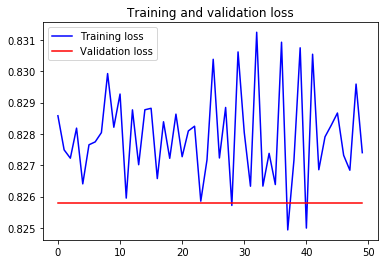

In [0]:
plot_train_history(multi_step_history, 'Training and validation loss')

(64, 512, 512, 1)


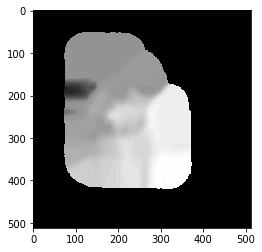

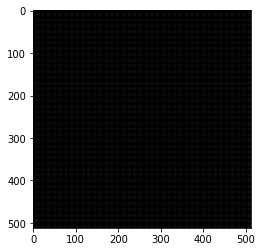

In [0]:
for x, y in val_data.take(1):
  out = CNN_LSTM_AE_model.predict(x)
  print(out.shape)
  plt.figure()
  plt.imshow(y[0,:,:,0], 'gray')
  plt.figure()
  plt.imshow(out[0,:,:,0], 'gray')

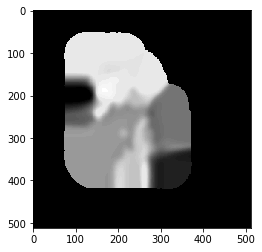

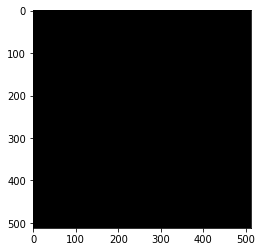

In [0]:
x = x_val[0:63]
y = y_val[0:63]
out = CNN_LSTM_AE_model.predict(x)
plt.figure()
plt.imshow(y[45,:,:,0], 'gray')
plt.figure()
plt.imshow(out[45,:,:,0], 'gray')